# Dependencies

In [1]:
!nvidia-smi

Fri Apr  1 11:15:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
from google.colab import files
files.upload() #upload kaggle.json
!pip install -q kaggle
!mkdir -p ~/.kaggle
import time
time.sleep(5)
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d ratthachat/efficientnet-keras-weights-b0b5
!unzip -q /content/efficientnet-keras-weights-b0b5.zip
!rm -rf /content/efficientnet-keras-weights-b0b5.zip

!kaggle datasets download -d ratan123/install
!unzip -q ./install.zip
!rm -rf /content/install.zip

!kaggle competitions download -c aptos2019-blindness-detection
!unzip -q ./aptos2019-blindness-detection
!rm -rf ./aptos2019-blindness-detection.zip

Saving kaggle.json to kaggle.json
kaggle.json
 94% 252M/268M [00:01<00:00, 156MB/s]
100% 268M/268M [00:02<00:00, 139MB/s]
  0% 0.00/10.3k [00:00<?, ?B/s]
100% 10.3k/10.3k [00:00<00:00, 10.1MB/s]
100% 9.51G/9.51G [00:57<00:00, 171MB/s]
100% 9.51G/9.51G [00:57<00:00, 177MB/s]


In [2]:
!pip list | grep tensor

tensorboard                   2.8.0
tensorboard-data-server       0.6.1
tensorboard-plugin-wit        1.8.1
tensorflow                    2.8.0
tensorflow-datasets           4.0.1
tensorflow-estimator          2.8.0
tensorflow-gcs-config         2.8.0
tensorflow-hub                0.12.0
tensorflow-io-gcs-filesystem  0.24.0
tensorflow-metadata           1.7.0
tensorflow-probability        0.16.0


In [3]:
!pip list | grep tf

In [4]:
!pip list | grep eras

keras                         2.8.0
Keras-Preprocessing           1.1.2
keras-vis                     0.4.1


In [5]:
!pip uninstall -y tensorflow==2.8.0 
!pip uninstall -y keras==2.8.0

!pip install tensorflow-gpu==1.14.0 
!pip install keras==2.2.4

!pip install -U './efficientnet-0.0.3-py2.py3-none-any.whl'

!pip uninstall h5py -y
!pip install h5py==2.10.0

Found existing installation: tensorflow 2.8.0
Uninstalling tensorflow-2.8.0:
  Successfully uninstalled tensorflow-2.8.0
Found existing installation: keras 2.8.0
Uninstalling keras-2.8.0:
  Successfully uninstalled keras-2.8.0
     |████████████████████████████████| 377.1 MB 9.6 kB/s 
     |████████████████████████████████| 488 kB 47.4 MB/s 
     |████████████████████████████████| 50 kB 6.4 MB/s 
     |████████████████████████████████| 3.1 MB 37.2 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
     |████████████████████████████████| 312 kB 5.3 MB/s 
Found existing installation: h5py 3.1.0
Uninstalling h5py-3.1.0:
  Successfully uninstalled h5py-3.1.0
  

In [ ]:
import tensorflow, keras
print(tensorflow.__version__)
print(keras.__version__)

# https://www.kaggle.com/datasets/ratthachat/efficientnet-keras-weights-b0b5
# https://www.kaggle.com/datasets/ratan123/install
# https://www.kaggle.com/competitions/aptos2019-blindness-detection

# Imports

In [1]:
# import libraries
import json
import math
from tqdm import tqdm, tqdm_notebook
import gc
import warnings
import os

import cv2
from PIL import Image

import pandas as pd
import scipy
import matplotlib.pyplot as plt

from keras import backend as K
from keras import layers
import keras
from efficientnet import EfficientNetB0
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
from keras.models import Sequential
from keras.optimizers import Adam
from keras.losses import binary_crossentropy, categorical_crossentropy
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
from glob import glob
import numpy as np

warnings.filterwarnings("ignore")

%matplotlib inline

Using TensorFlow backend.
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

# Partitioning and Preprocessing

(2489,) (2489,) (550,) (550,) (623,) (623,)


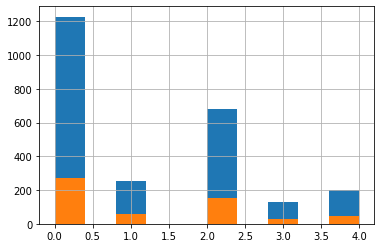

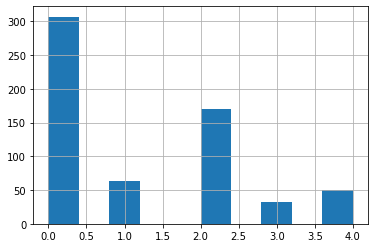

In [2]:

df_train = pd.read_csv('./train.csv')
df_test = pd.read_csv('./test.csv')

x = df_train['id_code']
y = df_train['diagnosis']

train_x, valid_x, train_y, valid_y = train_test_split(x, y, test_size=0.15,
                                                      stratify=y)#, random_state=16)
train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=0.2,
                                                      stratify=train_y)#, random_state=16)

print(train_x.shape, train_y.shape, valid_x.shape, valid_y.shape, test_x.shape, test_y.shape)
train_y.hist()
# plt.show()
valid_y.hist()
plt.show()
test_y.hist()
plt.show()

In [3]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

def circle_crop(img, sigmaX=10):   
    """
    Create circular crop around image centre    
    """    
    
    img = cv2.imread(img)[:,:,::-1]
    img = crop_image_from_gray(img)    
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    # img=cv2.addWeighted ( img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img 

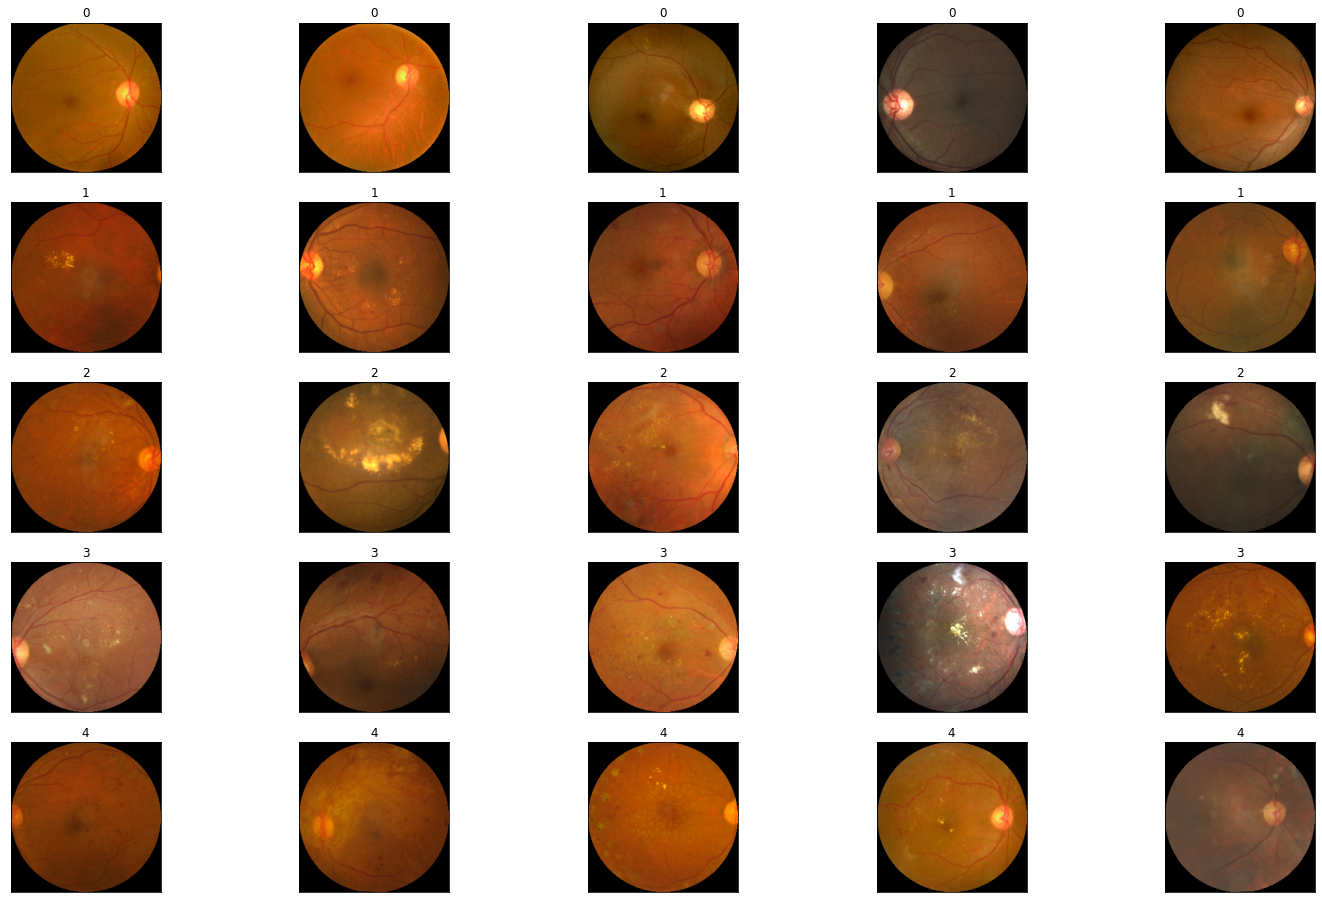

In [4]:
## try circle crop
NUM_SAMP=5
fig = plt.figure(figsize=(25, 16))
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['diagnosis'] == class_id].sample(NUM_SAMP).iterrows()):
        ax = fig.add_subplot(5, NUM_SAMP, class_id * NUM_SAMP + i + 1, xticks=[], yticks=[])
        path=f"./train_images/{row['id_code']}.png"
        image = circle_crop(path,sigmaX=30)
        image = cv2.resize(image, (224,224))
        plt.imshow(image)
        ax.set_title(class_id)
        

In [5]:
!rm -rf ./Dataset

!mkdir ./Dataset

!mkdir ./Dataset/train
!mkdir ./Dataset/train/0
!mkdir ./Dataset/train/1
!mkdir ./Dataset/train/2
!mkdir ./Dataset/train/3
!mkdir ./Dataset/train/4

!mkdir ./Dataset/val
!mkdir ./Dataset/val/0
!mkdir ./Dataset/val/1
!mkdir ./Dataset/val/2
!mkdir ./Dataset/val/3
!mkdir ./Dataset/val/4

!mkdir ./Dataset/test
!mkdir ./Dataset/test/0
!mkdir ./Dataset/test/1
!mkdir ./Dataset/test/2
!mkdir ./Dataset/test/3
!mkdir ./Dataset/test/4

In [6]:
error = []
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in tqdm(enumerate(df_train.loc[df_train['diagnosis'] == class_id].iterrows())):
        
        path=f"./train_images/{row['id_code']}.png"
        image = circle_crop(path,sigmaX=30)
        image = cv2.resize(image, (224,224))
        
        if row['id_code'] in list(train_x):
            cv2.imwrite(f"./Dataset/train/{class_id}/{row['id_code']}.png", image[:,:,::-1])
        elif row['id_code'] in list(valid_x):
            cv2.imwrite(f"./Dataset/val/{class_id}/{row['id_code']}.png", image[:,:,::-1])
        elif row['id_code'] in list(test_x):
            cv2.imwrite(f"./Dataset/test/{class_id}/{row['id_code']}.png", image[:,:,::-1])
        else:
            error.append(f"{class_id}/{row['id_code']}.png")

1805it [04:42,  6.39it/s]
370it [01:59,  3.09it/s]
999it [06:12,  2.68it/s]
193it [01:06,  2.91it/s]
295it [01:48,  2.71it/s]


In [7]:
print(error)
print(len(glob('./Dataset/train/*/*.png')))
print(len(glob('./Dataset/test/*/*.png')))
print(len(glob('./Dataset/val/*/*.png')))

!rm -rf ./backup
!mkdir ./backup
!cp -r ./Dataset/* ./backup/

!rm -rf /content/test_images
!rm -rf /content/train_images

[]
2489
623
550


# Data Generator and Model Building

In [4]:
train_datagen = ImageDataGenerator(rescale = 1/255.0,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   brightness_range = (0.1, 0.25),
                                   rotation_range = 20,
                                   vertical_flip = True,
                                   horizontal_flip = True,)

valid_datagen =  ImageDataGenerator(rescale = 1/255.0,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   brightness_range = (0.1, 0.25),
                                   rotation_range = 20,
                                   vertical_flip = True,
                                   horizontal_flip = True,)
 
test_datagen =  ImageDataGenerator(rescale = 1/255.0,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   brightness_range = (0.1, 0.25),
                                   rotation_range = 20,
                                   vertical_flip = True,
                                   horizontal_flip = True,)
    
    
training_set = train_datagen.flow_from_directory('./Dataset/train/',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',)

valid_set = valid_datagen.flow_from_directory('./Dataset/val/',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical',)

test_set = test_datagen.flow_from_directory('./Dataset/test/',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical',)

Found 2489 images belonging to 5 classes.
Found 550 images belonging to 5 classes.
Found 623 images belonging to 5 classes.


In [5]:
def build_model(base_model):
    model = Sequential()
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(5, activation='softmax'))
    
    model.compile(
        loss='categorical_crossentropy',
        #loss=kappa_loss,
        optimizer='adam',
        metrics=['accuracy']
    )
    
    return model







Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, 7, 7, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
batch_normalization_50 (Batc (None, 1280)              5120      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 6405      
Total params: 4,061,089
Trainable params: 4,016,513
Non-trainable params: 

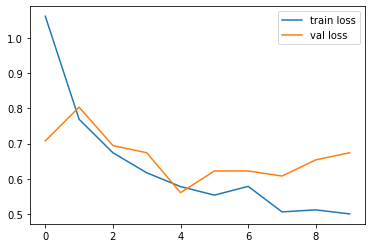

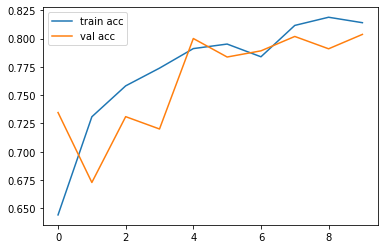

[0.7043477406923205, 0.7815292952314034]

In [6]:
callbacks = [
    CSVLogger("./Eff_history.csv"),
    # EarlyStopping(monitor="val_loss", patience=5)
]

base_model = EfficientNetB0(
        weights=None,
        input_shape=(224,224,3),
        include_top=False
                   )

base_model.load_weights("./efficientnet-b0_imagenet_1000_notop.h5")

model = build_model(base_model)
model.summary()

r1 = model.fit_generator(
  training_set,
  validation_data=valid_set,
#   batch_size=16,
  epochs=10,
  steps_per_epoch=len(training_set),
  workers=-1,
  use_multiprocessing=True,
  validation_steps=len(valid_set),
  callbacks=callbacks
)

# loss
plt.plot(r1.history['loss'], label='train loss')
plt.plot(r1.history['val_loss'], label='val loss')
plt.legend()
plt.show()
# plt.savefig('LossVal_loss')

# accuracies
plt.plot(r1.history['acc'], label='train acc')
plt.plot(r1.history['val_acc'], label='val acc')
plt.legend()
plt.show()
# plt.savefig('AccVal_acc')

model.save('./EfficientNetB0.h5')

model.evaluate_generator(test_set, steps=32, workers=-1, use_multiprocessing=True)



29089792/29084464 [==============================] - 0s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1024)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
batch_normalization_51 (Batc (None, 1024)              4096      
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 5125      
Total params: 7,046,725
Trainable params: 6,961,029
Non-trainable params: 85,696
_________________________________________________________________
Epoch 1/10
78/78 [==============================] - 175s 2s/

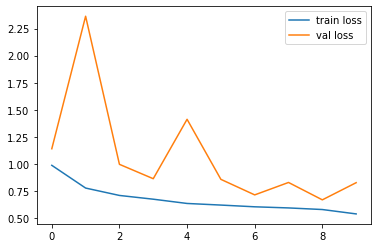

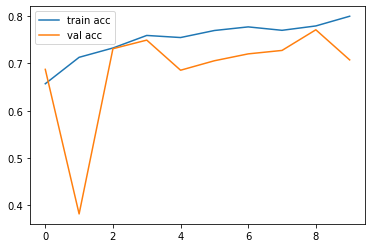

[0.8573883179763351, 0.721212121362638]

In [7]:
from keras.applications.densenet import DenseNet121
base_model = DenseNet121(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

callbacks = [
    CSVLogger("./DenseNet121_history.csv"),
    # EarlyStopping(monitor="val_loss", patience=5)
]

model = build_model(base_model)
model.summary()

r1 = model.fit_generator(
  training_set,
  validation_data=valid_set,
#   batch_size=16,
  epochs=10,
  steps_per_epoch=len(training_set),
  workers=-1,
  use_multiprocessing=True,
  validation_steps=len(valid_set),
  callbacks=callbacks
)

# loss
plt.plot(r1.history['loss'], label='train loss')
plt.plot(r1.history['val_loss'], label='val loss')
plt.legend()
plt.show()
# plt.savefig('LossVal_loss')

# accuracies
plt.plot(r1.history['acc'], label='train acc')
plt.plot(r1.history['val_acc'], label='val acc')
plt.legend()
plt.show()
# plt.savefig('AccVal_acc')

model.save('./DenseNet121.h5')

model.evaluate_generator(test_set, steps=32, workers=-1, use_multiprocessing=True)

219062272/219055592 [==============================] - 7s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 5, 5, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1536)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1536)              0         
_________________________________________________________________
batch_normalization_255 (Bat (None, 1536)              6144      
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 7685      
Total params: 54,350,565
Trainable params: 54,286,949
Non-trainable params: 63,616
_________________________________________________________________
Epoch 1/10
78/78 [==============================] - 276s 4

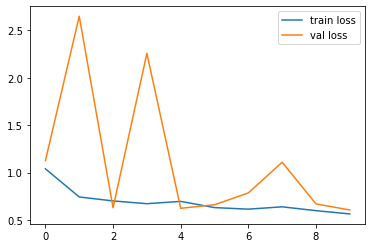

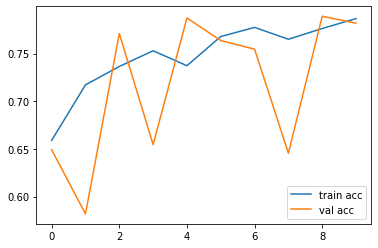

[0.571333895018463, 0.783515392372601]

In [8]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2
base_model = InceptionResNetV2(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
model = build_model(base_model)
model.summary()

callbacks = [
    CSVLogger("./InceptionResNetV2_history.csv"),
    # EarlyStopping(monitor="val_loss", patience=5)
]

r1 = model.fit_generator(
  training_set,
  validation_data=valid_set,
#   batch_size=32,
  epochs=10,
  steps_per_epoch=len(training_set),
  workers=-1,
  use_multiprocessing=True,
  validation_steps=len(valid_set),
  callbacks=callbacks
)

# loss
plt.plot(r1.history['loss'], label='train loss')
plt.plot(r1.history['val_loss'], label='val loss')
plt.legend()
plt.show()
# plt.savefig('LossVal_loss')

# accuracies
plt.plot(r1.history['acc'], label='train acc')
plt.plot(r1.history['val_acc'], label='val acc')
plt.legend()
plt.show()
# plt.savefig('AccVal_acc')

model.save('./InceptionResNetV2.h5')

model.evaluate_generator(test_set, steps=32, workers=-1, use_multiprocessing=True)

83689472/83683744 [==============================] - 5s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048)              0         
_________________________________________________________________
batch_normalization_260 (Bat (None, 2048)              8192      
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 10245     
Total params: 20,879,917
Trainable params: 20,821,293
Non-trainable params: 58,624
_________________________________________________________________
Epoch 1/10
78/78 [==============================] - 221s 3s/

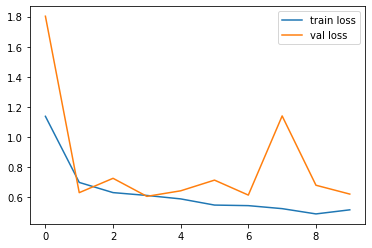

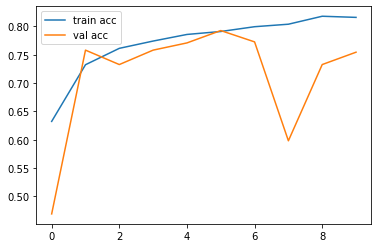

[0.6706646303335826, 0.765656566198426]

In [9]:
from keras.applications.xception import Xception
base_model = Xception(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
model = build_model(base_model)
model.summary()

callbacks = [
    CSVLogger("./Xception_history.csv"),
    # EarlyStopping(monitor="val_loss", patience=5)
]

r1 = model.fit_generator(
  training_set,
  validation_data=valid_set,
#   batch_size=32,
  epochs=10,
  steps_per_epoch=len(training_set),
  workers=-1,
  use_multiprocessing=True,
  validation_steps=len(valid_set),
  callbacks=callbacks
)

# loss
plt.plot(r1.history['loss'], label='train loss')
plt.plot(r1.history['val_loss'], label='val loss')
plt.legend()
plt.show()
# plt.savefig('LossVal_loss')

# accuracies
plt.plot(r1.history['acc'], label='train acc')
plt.plot(r1.history['val_acc'], label='val acc')
plt.legend()
plt.show()
# plt.savefig('AccVal_acc')

model.save('./Xception.h5')

model.evaluate_generator(test_set, steps=32, workers=-1, use_multiprocessing=True)

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
!cp ./Xception.h5 /content/drive/MyDrive/DR/
!cp ./InceptionResNetV2.h5 /content/drive/MyDrive/DR/
!cp ./DenseNet121.h5 /content/drive/MyDrive/DR/
!cp ./EfficientNetB0.h5 /content/drive/MyDrive/DR/